## SINDy in Julia 

Consider a dynamical system of the form: 

\begin{equation*}
    \frac{d}{dt} \mathbf{x}(t) = \mathbf{f}(\mathbf{x}(t)) \, 
\end{equation*}

where 
- $n$ is the number of states 
- $\mathbf{x}(t) \in \mathbb{R}^n$ is the system state at time $t$ 
- $\mathbf{f}(\mathbf{x}(t))$ represents the (unknown) equations of motion for the system. 

Now consider data measurements that are a linear combination of columns from a library of candidate functions: 
    
\begin{equation*}
    \mathbf{y} = \mathbf{\Theta \xi} \, 
\end{equation*}

where 

- $m$ is the amount of time samples of data 
- $p$ is the number of candidate functions. 
- $\mathbf{y} \in \mathbb{R}^m$ represents the data measurements  
- $\mathbf{\Theta} \in \mathbb{R}^{m \times p}$ is the library of candidate functions 
- $\mathbf{\xi} \in \mathbb{R}^p$ is the vector containing the linear combination of entries. 

SINDy identifies the equations of motion of a system through sparse regression. It seeks to minimize the cost function: 

\begin{equation*} 
    \operatorname*{argmin}_{\mathbf{\xi}} || \mathbf{\Theta \xi - y} ||_2 + \lambda || \mathbf{\xi} ||_1 \,  
\end{equation*} 

where 

- $ \lambda $ is a tuning parameter that regulate the size of $ \xi  $  

## Example 

Behold the Lorenz system: 


\begin{align*} 
\frac{dx}{dt} &=  \sigma (y - x)  \\ 
\frac{dy}{dt} &=  x (\rho - z) - y \\ 
\frac{dz}{dt} &= xy - \beta z 
\end{align*}

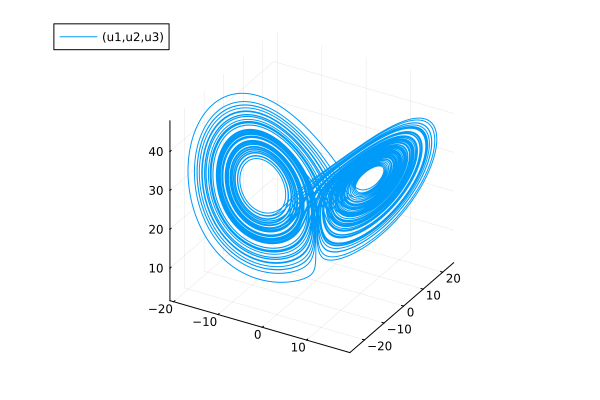

In [29]:
# specify packages 
using DataDrivenDiffEq
using DataDrivenSparse
using ModelingToolkit
using OrdinaryDiffEq
using LinearAlgebra
using Plots
gr()

# Create a test problem
function lorenz(u,p,t)
    x, y, z = u
    ẋ = 10.0*(y - x)
    ẏ = x*(28.0-z) - y
    ż = x*y - (8/3)*z
    return [ẋ, ẏ, ż]
end

# define ICs and params 
u0 = [-8.0; 7.0; 27.0] ; 
p  = [10.0; -10.0; 28.0; -1.0; -1.0; 1.0; -8/3] ; 
ts = (0.0,100.0) ; 
dt = 0.001 ; 

# solve ODE 
problem  = ODEProblem( lorenz, u0, ts ) ; 
solution = solve(problem, Tsit5(), saveat = dt, abstol = 1e-7, reltol = 1e-8) ; 

plot( solution, idxs = (1,2,3) ) 

Generate truth derivative data: 


In [24]:
X = Array(solution) ; 
DX = similar(X) ; 
for (i, xi) in enumerate(eachcol(X)) 
    DX[:,i] = lorenz(xi, [], 0.0) ; 
end 

To generate symbolic equations, define a basis over variables [x y z]. In this example, we will use monomials up to degree of 4 and their products: 

In [25]:
@variables x y z 
u = Operation[x; y; z] ; 
polys = Operation[] ; 

for i in 0:4 
    for j in 0:i 
        for k in 0:j 
            push!(polys, u[1]^i * u[2]^j * u[3]^k)
            push!(polys, u[2]^i * u[3]^j * u[1]^k)
            push!(polys, u[3]^i * u[1]^j * u[2]^k)
        end 
    end 
end 

LoadError: UndefVarError: Operation not defined